In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import pickle
from datetime import datetime
from datetime import timezone
from scipy.stats import t
from mat4py import loadmat
from distfit import distfit

In [2]:
red = (0.77, 0, 0.05) # (196, 0, 13)
blue = (0.12, 0.24, 1) # (31, 61, 255)
green = (0.31, 1, 0.34) # (79, 255, 87)
navyblue = (0, 0, 0.4) # (0, 0, 102)
black = (0, 0, 0)
white = (1, 1, 1)

powerdata_path = r"./data/siemens/hourly_avg_wind_speed_and_power.mat"
pricedata_path = r"./data/siemens/da_price_data_dk1_10AM.csv"

powerdata_dict_list = loadmat(powerdata_path, meta=False)
pricedata = pd.read_csv(pricedata_path)
pricedata.dropna(inplace=True)
pricedata['error'] = pricedata['forecast'] - pricedata['nominal']

# Get data out of singleton lists
powerdata_dict = {}
for key in powerdata_dict_list.keys():
    powerdata_dict[key] = [l[0] for l in powerdata_dict_list[key]]
powerdata = pd.DataFrame(powerdata_dict)

# Features

In [3]:

df_DK2_2019 = pd.read_csv('./data/ENTSOE_Generation Forecasts for Wind and Solar_DK2_201901010000-202001010000.csv')
df_DK2_2020 = pd.read_csv('./data/ENTSOE_Generation Forecasts for Wind and Solar_DK2_202001010000-202101010000.csv')
df_DK2_2021 = pd.read_csv('./data/ENTSOE_Generation Forecasts for Wind and Solar_DK2_202101010000-202201010000.csv')

df_DK1_2019 = pd.read_csv('./data/ENTSOE_Generation Forecasts for Wind and Solar_DK1_201901010000-202001010000.csv')
df_DK1_2020 = pd.read_csv('./data/ENTSOE_Generation Forecasts for Wind and Solar_DK1_202001010000-202101010000.csv')
df_DK1_2021 = pd.read_csv('./data/ENTSOE_Generation Forecasts for Wind and Solar_DK1_202101010000-202201010000.csv')

df_r_2019 = pd.read_csv('./data/ENTSOE_Actual Generation Roedsand 2_201901010000-202001020000.csv')
df_r_2020 = pd.read_csv('./data/ENTSOE_Actual Generation Roedsand 2_202001010000-202101020000.csv')
df_r_2021 = pd.read_csv('./data/ENTSOE_Actual Generation Roedsand 2_202101010000-202201020000.csv')

## Unused mistake

In [4]:
chosen_params = ['wind_speed', 'wind_speed_past1h', 'wind_gust_always_past1h', 'wind_max', 'wind_min_past1h', 'wind_min', 'wind_max_per10min_past1h']

reformat_data = False   #-----------Reformatting takes ~15 min!
load_data = False       #-----------Loading takes only ~10sec 


if (reformat_data):
    #-------datestrings created for reading all the txt files
    with open('./datestrings.csv') as f:
        datestrings_raw = f.readlines()

    datestrings = []
    for i in range(len(datestrings_raw)):
        datestrings.append(datestrings_raw[i][:-1])

    datestrings[0] = datestrings[0][3:]

    def read_day(datestr):
        with open(f'./vejrdata/{datestr}.txt') as f:
            lines = f.readlines()

        data_list = []
        for line in lines:
            json_data = json.loads(line)
            param = json_data['properties']['parameterId']
            if param in chosen_params:
                if json_data['properties']['stationId'] == '06138' or json_data['properties']['stationId'] == '06149':
                    data_list.append(json_data)

        return data_list

    all_data = []
    for datestr in datestrings:
        if (datestr == '2019-07-01'):
            print("Halfway through 2019")
        elif (datestr == '2020-01-01'):
            print("Beginning 2020")
        elif (datestr == '2020-07-01'):
            print("Halfway through 2020")
        elif (datestr == '2021-01-01'):
            print("Beginning 2021")
        elif (datestr == '2021-07-01'):
            print("Halfway through 2021")
        all_data += read_day(datestr)

    with open('all_json_data_reformatted', "wb") as f:
        pickle.dump(all_data, f)



if (load_data):
    with open("all_json_data", "rb") as f:
        all_data = pickle.load(f)

In [5]:
gedser_data = {}
langoe_data = {}
for param in chosen_params:
    gedser_data[param] = []
    langoe_data[param] = []
    
for i in range(len(all_data)):
    param = all_data[i]['properties']['parameterId']
    if param in chosen_params:
        obs_time = datetime.fromisoformat(all_data[i]['properties']['observed'][:-1]).astimezone(timezone.utc)
        # obs_time = obs_time.strftime('%Y-%m-%d %H:%M:%S')
        obs = [obs_time, all_data[i]['properties']['value']]
        if all_data[i]['properties']['stationId'] == '06138':
            langoe_data[param].append(obs)
        if all_data[i]['properties']['stationId'] == '06149':
            gedser_data[param].append(obs)

for param in chosen_params:
    print(f"{param} has {len(gedser_data[param])} datapoints in gedser_data")
    print(f"{param} has {len(langoe_data[param])} datapoints in langoe_data")

wind_speed has 157728 datapoints in gedser_data
wind_speed has 155856 datapoints in langoe_data
wind_speed_past1h has 26288 datapoints in gedser_data
wind_speed_past1h has 25976 datapoints in langoe_data
wind_gust_always_past1h has 26288 datapoints in gedser_data
wind_gust_always_past1h has 25976 datapoints in langoe_data
wind_max has 157725 datapoints in gedser_data
wind_max has 155855 datapoints in langoe_data
wind_min_past1h has 1930 datapoints in gedser_data
wind_min_past1h has 1617 datapoints in langoe_data
wind_min has 890 datapoints in gedser_data
wind_min has 418 datapoints in langoe_data
wind_max_per10min_past1h has 26289 datapoints in gedser_data
wind_max_per10min_past1h has 25976 datapoints in langoe_data


In [6]:
final_n_datapoints = 365+365+366 # We want a datapoint for each hour
final_params = ['wind_speed_past1h', 'wind_gust_always_past1h', 'wind_max_per10min_past1h']

# Create list of indices
with open('./datestrings.csv') as f:
    datestrings_raw = f.readlines()

datestrings = []
for i in range(len(datestrings_raw)):
    datestrings.append(datestrings_raw[i][:-1])

datestrings[0] = datestrings[0][3:]
hours = 24
months = 12
days_list_2019 = [31,28,31,30,31,30,31,31,30,31,30,31]
days_list_2020 = [31,29,31,30,31,30,31,31,30,31,30,31]
days_list_2021 = [31,28,31,30,31,30,31,31,30,31,30,31]
days_list = [days_list_2019, days_list_2020, days_list_2021]
years = [2019, 2020, 2021]

index_list = [datetime(yy, mm+1, dd+1, h).astimezone(timezone.utc) for i, yy in enumerate(years) for mm in range(months) for dd in range(days_list[i][mm]) for h in range(hours)]

data_date_list = [gedser_data[final_params[0]][i][0] for i in range(len(gedser_data[final_params[0]]))]
missing_list = list(set(index_list) - set(data_date_list)) # Using sets for O(1) speed


### Checking if missing values are randomly spread so we can use backfill

In [172]:
data_date_list = [gedser_data[final_params[0]][i][0] for i in range(len(gedser_data[final_params[0]]))]
missing_list = list(set(index_list) - set(data_date_list)) # Using sets for O(1) speed
missing_list


[datetime.datetime(2021, 2, 28, 23, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 9, 14, 6, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 12, 30, 1, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 9, 24, 12, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 1, 24, 2, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 1, 8, 1, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 8, 11, 8, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 9, 14, 7, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 9, 11, 5, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 11, 30, 18, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 12, 30, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 1, 17, 12, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 2, 28, 23, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 8, 11, 9, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 9,

In [163]:
data_date_list = [gedser_data[final_params[1]][i][0] for i in range(len(gedser_data[final_params[0]]))]
missing_list = list(set(index_list) - set(data_date_list)) # Using sets for O(1) speed
missing_list

[datetime.datetime(2021, 12, 30, 1, 0),
 datetime.datetime(2021, 11, 30, 19, 0),
 datetime.datetime(2020, 1, 17, 13, 0),
 datetime.datetime(2020, 8, 11, 10, 0),
 datetime.datetime(2021, 9, 24, 14, 0),
 datetime.datetime(2020, 8, 11, 11, 0),
 datetime.datetime(2019, 3, 7, 0, 0),
 datetime.datetime(2021, 3, 1, 0, 0),
 datetime.datetime(2019, 9, 11, 7, 0),
 datetime.datetime(2021, 9, 14, 9, 0),
 datetime.datetime(2021, 12, 30, 2, 0),
 datetime.datetime(2019, 3, 1, 0, 0),
 datetime.datetime(2021, 9, 14, 8, 0),
 datetime.datetime(2020, 1, 8, 2, 0),
 datetime.datetime(2019, 9, 11, 8, 0),
 datetime.datetime(2021, 9, 14, 10, 0)]

In [164]:
data_date_list = [gedser_data[final_params[2]][i][0] for i in range(len(gedser_data[final_params[0]]))]
missing_list = list(set(index_list) - set(data_date_list)) # Using sets for O(1) speed
missing_list

[datetime.datetime(2021, 12, 30, 1, 0),
 datetime.datetime(2021, 11, 30, 19, 0),
 datetime.datetime(2020, 1, 17, 13, 0),
 datetime.datetime(2020, 8, 11, 10, 0),
 datetime.datetime(2021, 9, 24, 14, 0),
 datetime.datetime(2020, 8, 11, 11, 0),
 datetime.datetime(2021, 3, 1, 0, 0),
 datetime.datetime(2019, 9, 11, 7, 0),
 datetime.datetime(2021, 12, 31, 0, 0),
 datetime.datetime(2021, 9, 14, 9, 0),
 datetime.datetime(2021, 12, 30, 2, 0),
 datetime.datetime(2019, 3, 1, 0, 0),
 datetime.datetime(2021, 9, 14, 8, 0),
 datetime.datetime(2020, 1, 8, 2, 0),
 datetime.datetime(2019, 9, 11, 8, 0),
 datetime.datetime(2021, 9, 14, 10, 0)]

In [18]:
data_date_list = [langoe_data[final_params[0]][i][0] for i in range(len(langoe_data[final_params[0]]))]
missing_list = list(set(index_list) - set(data_date_list)) # Using sets for O(1) speed
missing_list

[datetime.datetime(2020, 9, 21, 23, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 12, 24, 20, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 12, 31, 15, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2020, 9, 22, 6, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 12, 29, 16, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 12, 23, 21, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 12, 23, 15, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 12, 29, 14, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 12, 27, 7, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 3, 6, 23, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 12, 28, 11, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 12, 23, 19, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 12, 24, 1, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2021, 12, 28, 9, 0, tzinfo=datetime.timezone.utc),
 datetime.date

### They are randomly spread!

In [35]:
df_gedser = pd.DataFrame()
df_gedser.index = pd.date_range(start = '2019-01-01', end = '2022-01-01', freq="1h", tz='UTC')
df_gedser['datetime'] = pd.date_range(start = '2019-01-01', end = '2022-01-01', freq="1h")
df_gedser.drop(df_gedser.index[-1], inplace=True) # Last datetime is first hour in 2022 so should be removed

df_langoe = pd.DataFrame()
df_langoe.index = pd.date_range(start = '2019-01-01', end = '2022-01-01', freq="1h", tz='UTC')
df_langoe['datetime'] = pd.date_range(start = '2019-01-01', end = '2022-01-01', freq="1h")
df_langoe.drop(df_langoe.index[-1], inplace=True) # Last datetime is first hour in 2022 so should be removed


final_params = ['wind_speed_past1h', 'wind_gust_always_past1h', 'wind_max_per10min_past1h']

for param in final_params:
    values = [gedser_data[param][i][1] for i in range(len(gedser_data[param]))]
    indices = [gedser_data[param][i][0] for i in range(len(gedser_data[param]))]
    df_ = pd.DataFrame(pd.Series(values, index=indices)).sort_index()
    df_no_duplicates = df_.loc[~df_.index.duplicated(), :]
    ws_data = pd.Series(df_no_duplicates[0], index=df_no_duplicates.index)
    df_gedser.insert(1, f"{param}_g", ws_data)


for param in final_params:
    values = [langoe_data[param][i][1] for i in range(len(langoe_data[param]))]
    indices = [langoe_data[param][i][0] for i in range(len(langoe_data[param]))]
    df_ = pd.DataFrame(pd.Series(values, index=indices)).sort_index()
    df_no_duplicates = df_.loc[~df_.index.duplicated(), :]
    ws_data = pd.Series(df_no_duplicates[0], index=df_no_duplicates.index)
    df_langoe.insert(1, f"{param}_l", ws_data)


df_weather = pd.concat([df_gedser, df_langoe], axis=1)
df_weather.drop(columns=["datetime"], inplace=True)
df_weather.head()

,wind_max_per10min_past1h_g,wind_gust_always_past1h_g,wind_speed_past1h_g,wind_max_per10min_past1h_l,wind_gust_always_past1h_l,wind_speed_past1h_l
2019-01-01 00:00:00+00:00,12.6,14.7,12.0,11.3,14.6,10.5
2019-01-01 01:00:00+00:00,14.1,16.8,13.1,12.4,15.9,12.0
2019-01-01 02:00:00+00:00,14.3,18.6,13.4,12.8,15.8,11.7
2019-01-01 03:00:00+00:00,14.6,17.2,14.2,12.8,16.9,12.0
2019-01-01 04:00:00+00:00,15.5,18.5,14.8,14.2,18.5,13.2


## Done with mistake

In [4]:
dk1_list = [df_DK1_2019, df_DK1_2020, df_DK1_2021]
df_DK1 = pd.concat(dk1_list).reset_index()
dk2_list = [df_DK2_2019, df_DK2_2020, df_DK2_2021]
df_DK2 = pd.concat(dk2_list).reset_index()
df_r_list = [df_r_2019.dropna(subset=['MTU'], how='all')[:8760], df_r_2020.dropna(subset=['MTU'], how='all')[:(8760+24)], df_r_2021.dropna(subset=['MTU'], how='all')[:8760]]
df_r = pd.concat(df_r_list).reset_index()

df_DK1.set_index("MTU (CET/CEST)", inplace=True)
df_DK1 = df_DK1.loc[~df_DK1.index.duplicated(), :]

df_DK2.set_index("MTU (CET/CEST)", inplace=True)
df_DK2 = df_DK2.loc[~df_DK2.index.duplicated(), :]


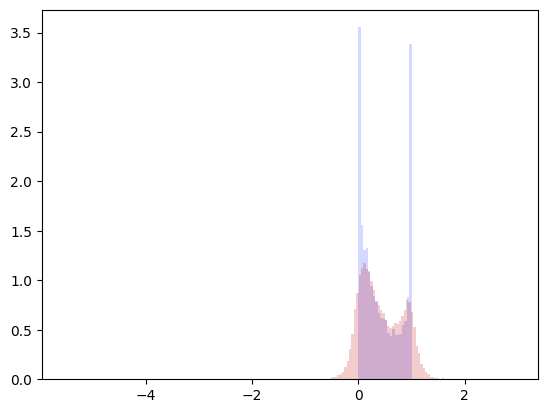

In [10]:
realized = df_r['Generation [MW]'].to_numpy().astype(float)
realized = realized / realized.max()
# Draw samples
# t_samples_power = t.rvs(3.3465, loc=-11.0358, scale=342.945, size=len(realized))
t_samples_power = t.rvs(3.3465, loc=-11.0358, scale=342.945, size=len(realized))

# Scale from 3 GW to 10 MW
t_samples_power *= np.max(realized)/3000

# forecast = []
# for i in range(len(realized)):
#     if realized[i] + t_samples_power[i] < 0 or realized[i] + t_samples_power[i] > np.max(realized):
#         forecast.append(realized[i] - t_samples_power[i])
#     else:
#         forecast.append(realized[i] + t_samples_power[i])

# forecast = np.minimum(np.maximum(realized + t_samples_power, 0), np.max(realized))
forecast = realized + t_samples_power
fig, ax = plt.subplots()
ax.hist(realized, density=True, bins='auto', histtype='stepfilled', alpha=0.2, color=blue)
ax.hist(forecast, density=True, bins='auto', histtype='stepfilled', alpha=0.2, color=red)
# ax.hist(errors, density=True, bins='auto', histtype='stepfilled', alpha=0.2, color="red")
fig.show()

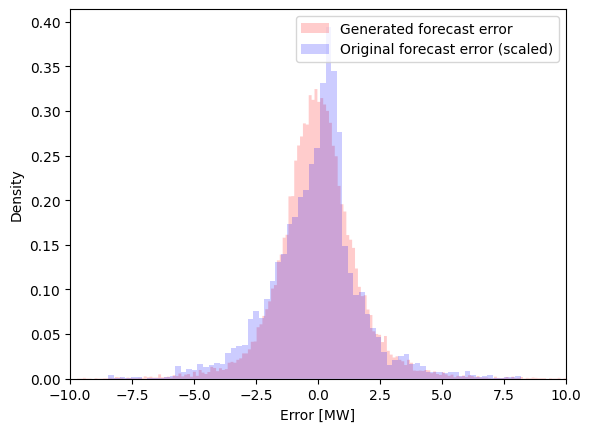

In [11]:
forecast_error = (forecast - realized)*10
powerdata['error_wp'] = powerdata['hourly_avg_FC_wp'] - powerdata['hourly_avg_RE_wp']

normalized_generated = forecast_error
normalized_original = powerdata['error_wp'] / powerdata['error_wp'].std() * forecast_error.std()
fig, ax = plt.subplots()
ax.hist(normalized_generated, density=True, bins='auto', color="red", histtype='stepfilled', alpha=0.2, label="Generated forecast error")
ax.hist(normalized_original, density=True, bins='auto', color="blue", histtype='stepfilled', alpha=0.2, label="Original forecast error (scaled)")
ax.legend()
ax.set_xlabel("Error [MW]")
ax.set_ylabel("Density")
ax.set_xlim(-10,10)
fig.show()
fig.savefig("production_forecast_error.pdf")

In [9]:
# df_forecasts = df_weather.copy()
df_forecasts = pd.DataFrame()
df_forecasts['realized'] = realized
df_forecasts['forecast'] = forecast
df_forecasts['offshore_DK2'] = df_DK2['Generation - Wind Offshore  [MW] Day Ahead/ BZN|DK2'].to_numpy().astype(float)
df_forecasts['offshore_DK1'] = df_DK1['Generation - Wind Offshore  [MW] Day Ahead/ BZN|DK1'].to_numpy().astype(float)
df_forecasts['onshore_DK2'] = df_DK2['Generation - Wind Onshore  [MW] Day Ahead/ BZN|DK2'].to_numpy().astype(float)
df_forecasts['onshore_DK1'] = df_DK1['Generation - Wind Onshore  [MW] Day Ahead/ BZN|DK1'].to_numpy().astype(float)
df_forecasts['solar_DK2'] = df_DK2['Generation - Solar  [MW] Day Ahead/ BZN|DK2'].to_numpy().astype(float)


df_forecasts.head()

,realized,forecast,offshore_DK2,offshore_DK1,onshore_DK2,onshore_DK1,solar_DK2
0,0.995098,0.903798,253.0,586.0,551.0,2302.0,0.0
1,1.000000,0.926969,328.0,627.0,645.0,2342.0,0.0
2,1.000000,1.000000,257.0,254.0,590.0,2227.0,0.0
3,0.995098,0.990921,210.0,233.0,566.0,2163.0,0.0
4,1.000000,1.000000,204.0,233.0,559.0,2108.0,0.0


In [30]:

#--------Normalize for stability
for i in range(df_forecasts.shape[1]-1):
    df_forecasts.iloc[:, i] = df_forecasts.iloc[:, i] / df_forecasts.iloc[:, i].max()

df_forecasts.head()

,realized,forecast,offshore_DK2,offshore_DK1,onshore_DK2,onshore_DK1,solar_DK2
0,0.995098,1.000000,0.274701,0.506045,0.680247,0.659599,0.0
1,1.000000,1.000000,0.356135,0.541451,0.796296,0.671060,0.0
2,1.000000,0.776486,0.279045,0.219344,0.728395,0.638109,0.0
3,0.995098,0.935938,0.228013,0.201209,0.698765,0.619771,0.0
4,1.000000,1.000000,0.221498,0.201209,0.690123,0.604011,0.0


In [31]:
#----------Forecasts are noisy anyway, so skewing 1 hour is not detrimental
df_forecasts.fillna(method="ffill", inplace=True)
df_forecasts.isnull().values.any()
# df_forecasts['offshore_DK1'].isnull().values.any()
# df_forecasts['solar_DK2'].isnull().sum()

False

In [32]:
#-----------Final check
df_forecasts.shape

(26304, 7)

In [23]:
SAVE_AS_CSV = True
if (SAVE_AS_CSV):
    df_forecasts.to_csv('./data/features.csv')

# Prices

In [12]:
df_price_2019 = pd.read_csv('./data/ENTSOE_Day-ahead Prices_201901010000-202001010000.csv')
df_price_2020 = pd.read_csv('./data/ENTSOE_Day-ahead Prices_202001010000-202101010000.csv')
df_price_2021 = pd.read_csv('./data/ENTSOE_Day-ahead Prices_202101010000-202201010000.csv')
df_price_2019.dropna(subset=['Day-ahead Price [EUR/MWh]'], inplace=True)
df_price_2020.dropna(subset=['Day-ahead Price [EUR/MWh]'], inplace=True)
df_price_2021.dropna(subset=['Day-ahead Price [EUR/MWh]'], inplace=True)
df_price_2019.reset_index(inplace=True)
df_price_2020.reset_index(inplace=True)
df_price_2021.reset_index(inplace=True)


df_price = pd.DataFrame()
df_price["Forward"] = pd.concat([df_price_2019['Day-ahead Price [EUR/MWh]'], df_price_2020['Day-ahead Price [EUR/MWh]'], df_price_2021['Day-ahead Price [EUR/MWh]']])


df_price.reset_index(inplace=True, drop=True)
df_price.drop([24818], inplace=True)
df_price.loc[len(df_price.index)+1] = [46.6]
df_price.reset_index(inplace=True, drop=True)
df_price.to_csv('./data/forward.csv')

In [13]:
df_imbalance_2019 = pd.read_csv('./data/ENTSOE_Imbalance_201901010000-202001010000.csv')
df_imbalance_2020 = pd.read_csv('./data/ENTSOE_Imbalance_202001010000-202101010000.csv')
df_imbalance_2021_all = pd.read_csv('./data/remaining_balancing_data.csv', delimiter=";", decimal=",")

df_imbalance_2021_all['HourUTC'] = pd.to_datetime(df_imbalance_2021_all['HourUTC'], format='%Y-%m-%d %H:%M')
df_imbalance_2021_all.set_index("HourUTC", inplace=True)

#--------fix based on analysis
df_imbalance_2019["Generation / + Imbalance price [EUR/MWh] - MBA|DK2"][6826] = 30.43
df_imbalance_2019["Generation / - Imbalance price [EUR/MWh] - MBA|DK2"][6826] = 35.24
df_imbalance_2019.dropna(subset=['Generation / + Imbalance price [EUR/MWh] - MBA|DK2'], inplace=True)

df_imbalance_2020.dropna(subset=['Generation / + Imbalance price [EUR/MWh] - MBA|DK2'], inplace=True)

df_imbalance_2021_all = pd.concat([df_imbalance_2021_all, pd.Series(np.nan)])
df_imbalance_2021_all["BalancingPowerPriceDownEUR"][-1] = 46.60
df_imbalance_2021_all["BalancingPowerPriceUpEUR"][-1] = 46.60

df_imbalance_dw = pd.concat([df_imbalance_2019["Generation / + Imbalance price [EUR/MWh] - MBA|DK2"], df_imbalance_2020["Generation / + Imbalance price [EUR/MWh] - MBA|DK2"], df_imbalance_2021_all["BalancingPowerPriceDownEUR"]]).reset_index()
df_imbalance_up = pd.concat([df_imbalance_2019["Generation / - Imbalance price [EUR/MWh] - MBA|DK2"], df_imbalance_2020["Generation / - Imbalance price [EUR/MWh] - MBA|DK2"], df_imbalance_2021_all["BalancingPowerPriceUpEUR"]]).reset_index()

df_imbalance = pd.DataFrame({"Up": df_imbalance_up[0].to_numpy(), "Down": df_imbalance_dw[0].to_numpy(), "Forward": df_price["Forward"]})

df_imbalance['SinglePrice'] = np.where(df_imbalance['Up'] != df_imbalance['Forward'], df_imbalance['Up'], df_imbalance['Down'])

df_imbalance.head()


# df_imbalance['Single price'] = np.select(conditions, values)
# pd.date_range(start = '2021-01-01', end = '2022-01-01', freq="1h").difference(df_imbalance_2021_all.index)
df_imbalance.to_csv('./data/prices.csv')

In [14]:
# df = 1.44887
# mean, var, skew, kurt = t.stats(df, moments='mvsk')
# x = np.linspace(t.ppf(0.01, df),
#                 t.ppf(0.99, df), 100)
# rv = t(df, loc=0.389, scale=12.089)

# r = t.rvs(df, loc=0.389, scale=12.089, size=1000)
# fig, ax = plt.subplots()
# ax.hist(pricedata['error'], density=True, bins='auto', histtype='stepfilled', alpha=0.2)
# ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
# ax.set_xlim([-200, 200])
# ax.legend(loc='best', frameon=False)
# fig.show()



t_samples_price = t.rvs(1.44887, loc=0.389, scale=12.089, size=len(df_imbalance["Forward"].to_numpy()))
t_samples_price *= 1/871.0*254.44

forecast = df_imbalance["Forward"].to_numpy() + t_samples_price

# price_forecasts = df_imbalance[["Forward"]]


In [15]:
df_forecasts.head()

# all_data = pd.read_csv("./data/2022_data.csv")
# all_data.head()

,realized,forecast,offshore_DK2,offshore_DK1,onshore_DK2,onshore_DK1,solar_DK2
0,0.995098,0.903798,253.0,586.0,551.0,2302.0,0.0
1,1.000000,0.926969,328.0,627.0,645.0,2342.0,0.0
2,1.000000,1.000000,257.0,254.0,590.0,2227.0,0.0
3,0.995098,0.990921,210.0,233.0,566.0,2163.0,0.0
4,1.000000,1.000000,204.0,233.0,559.0,2108.0,0.0


In [62]:
df_imbalance.iloc[17638:17648, :]

df_forecasts
# ["forward_RE", "forward_FC", "UP", "DW", "production_RE", "production_FC", "Offshore DK2", "Offshore DK1", "Onshore DK2", "Onshore DK1"]
df_all = pd.DataFrame()
df_all["forward_RE"] = df_imbalance[["Forward"]]
df_all["forward_FC"] = forecast
df_all["UP"] = df_imbalance[["Up"]]
df_all["DW"] = df_imbalance[["Down"]]
df_all["production_RE"] = df_forecasts[["realized"]]
df_all["production_FC"] = df_forecasts[["forecast"]]
df_all["Offshore DK2"] = df_forecasts[["offshore_DK2"]]
df_all["Offshore DK1"] = df_forecasts[["offshore_DK1"]]
df_all["Onshore DK2"] = df_forecasts[["onshore_DK2"]]
df_all["Onshore DK1"] = df_forecasts[["onshore_DK1"]]

In [9]:
import pandas as pd
df_all = pd.read_csv("./data/2020_data.csv")

df_all.drop(columns=["Unnamed: 0"], inplace=True)
df_all.head()

,forward_RE,forward_FC,UP,DW,production_RE,production_FC,Offshore DK2,Offshore DK1,Onshore DK2,Onshore DK1
0,28.32,35.395866,28.32,28.32,0.995098,1.000000,0.274701,0.506045,0.680247,0.659599
1,10.07,35.127035,10.07,10.07,1.000000,1.000000,0.356135,0.541451,0.796296,0.671060
2,-4.08,-3.707266,-4.08,-4.08,1.000000,0.776486,0.279045,0.219344,0.728395,0.638109
3,-9.91,-17.375766,-9.91,-9.91,0.995098,0.935938,0.228013,0.201209,0.698765,0.619771
4,-7.41,-7.552286,-7.41,-7.41,1.000000,1.000000,0.221498,0.201209,0.690123,0.604011


In [10]:

df_all = df_all.iloc[:2*8760,:]
df_all.shape

(17520, 10)

In [17]:
import numpy as np

np.quantile(df_all["forward_RE"].to_numpy(), 0.9)

53.32

In [8]:
df_all.to_csv("./data/2020_data.csv")

## System status

In [30]:
def get_meaned(prices):
    hourly_prices = {}
    for i in range(24):
        hourly_prices[f"hour_{i}"] = 0
    for i in range(len(prices)):
        hourly_prices[f"hour_{i % 24}"] += prices[i]

    for i in range(24):
        hourly_prices[f"hour_{i}"] *= 1/(len(prices)/24)
    meaned_prices = list(hourly_prices.values())
    final_prices = [meaned_prices[i%24] for i in range(26304)]
    return final_prices


In [280]:
df_quick = pd.read_csv("./data/prices_and_status.csv")
df_save = df_quick.iloc[:8760+8784,:]
df_save.to_csv("./data/prices_and_status_no2021.csv")

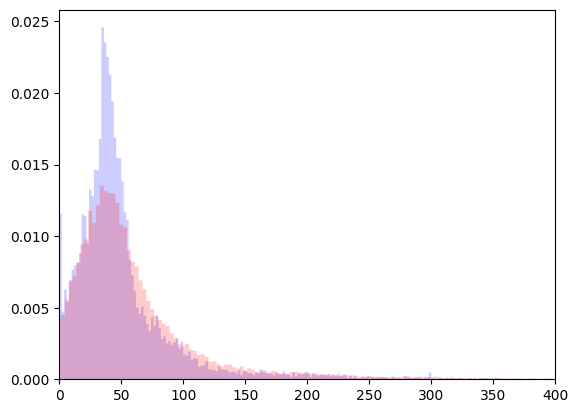

In [19]:
forward = df_price["Forward"].to_numpy()


# Draw samples
t_samples_price = t.rvs(1.44887, loc=0.389, scale=12.089, size=len(forward))

# forecast_price = np.maximum(forward + t_samples_price, 0)
forecast_price = forward + t_samples_price
forward = np.maximum(forward, 0)
errors = forecast_price - forward

fig, ax = plt.subplots()
ax.hist(forward, density=True, bins='auto', histtype='stepfilled', alpha=0.2, color="blue", label="Price")
ax.hist(forecast_price, density=True, bins='auto', histtype='stepfilled', alpha=0.2, color="red")
ax.set_xlim([0, 400])
ax.legend()
# ax.hist(errors, density=True, bins='auto', histtype='stepfilled', alpha=0.2, color="red")
fig.show()
fig.savefig("price_forecast_error.pdf")

In [26]:
df_price = pd.read_csv("./data/prices.csv")
df_price["SystemDeficit"] = 1 * np.greater(np.around(df_price["SinglePrice"], 2) - df_price["Forward"], 0)
df_price["SystemSurplus"] = 1 * np.less(np.around(df_price["SinglePrice"], 2) - df_price["Forward"], 0)
df_price["HydrogenStatus"] = 1 * np.greater_equal(df_price["Forward"], 35.2)
df_price["HydrogenMax_pred"] = df_price["HydrogenStatus"] * df_price["SystemDeficit"]
df_price["HydrogenMin_pred"] = (1 - df_price["HydrogenStatus"]) * df_price["SystemSurplus"]
df_price["HydrogenMax_real"] = 1 * np.less_equal(df_price["SinglePrice"], 35.2)
df_price["HydrogenMin_real"] = 1 * np.greater(df_price["SinglePrice"], 35.2)

#---------Lav den her
# df_price["forecasted_forward_price"] = df_price["Forward"] + (np.random.random(len(df_price["Forward"]))-0.5)*df_price["Forward"].std()*0.08
df_price["forecasted_forward_price"] = forecast_price

# df_price["meaned_forward_price"] = get_meaned(df_price["Forward"][:2*8760])

df_price.drop(columns=["Unnamed: 0"], inplace=True)


df_price.to_csv("./data/prices_and_status.csv")
df_price.head()

,Up,Down,Forward,SinglePrice,SystemDeficit,SystemSurplus,HydrogenStatus,HydrogenMax_pred,HydrogenMin_pred,HydrogenMax_real,HydrogenMin_real,forecasted_forward_price
0,28.32,28.32,28.32,28.32,0,0,0,0,0,1,0,48.575327
1,10.07,10.07,10.07,10.07,0,0,0,0,0,1,0,12.492707
2,-4.08,-4.08,-4.08,-4.08,0,0,0,0,0,1,0,21.071534
3,-9.91,-9.91,-9.91,-9.91,0,0,0,0,0,1,0,0.000000
4,-7.41,-7.41,-7.41,-7.41,0,0,0,0,0,1,0,0.000000


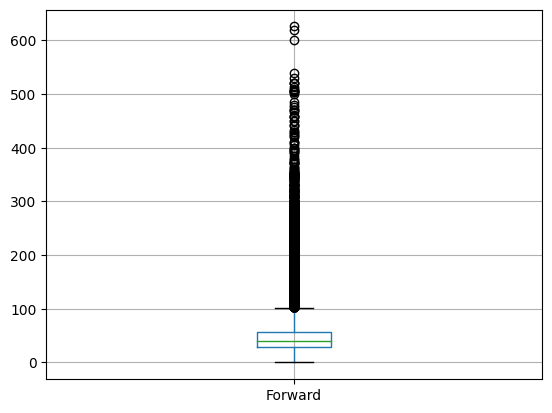

In [257]:
df_plotter = pd.DataFrame(np.maximum(0, df_price["Forward"]))
df_plotter.boxplot(column="Forward")
plt.show()

In [276]:
pd.DataFrame(np.maximum(0, df_price["Forward"])).quantile(1)
df_price["Forward"].max()

626.06

In [17]:
df_features_no_fc = pd.read_csv('./data/features_plus_fc.csv')

# df_features_no_fc['fc_noisy'] = df_features_no_fc["realized"] + (np.random.random(len(df_features_no_fc["realized"]))-0.5)*df_features_no_fc["realized"].std()*0.08

df_features_no_fc.drop(columns=["Unnamed: 0.1", "Unnamed: 0"], inplace=True)
df_features_no_fc.head()
df_features_no_fc.to_csv('./data/features_plus_fc.csv')

In [ ]:
# Baseret på figur 2 fra "Intraday_Trading_of_Wind_Energy":
pred_1 = 0.91
pred_2 = 0.86
pred_3 = 0.82
pred_4 = 0.78
pred_5 = 0.76
# Det er altså sandsyngligheder for at vi forudsiger den rigtige system status

# Get the true system status for all datapoints:


# Get bernoulli samples for each prediction hour:



# If sample is 1, put in the true status, if sample is 0 put in the opposite:



